# Hypothesis
- There are items that has item visibility of 0 but still has sales that means that they weren't recorded due to a glitch and that they will be treated the same as a null value.
- Item MRP is directly proportional to sales

# Loading Packages and Data

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import seaborn as sns
from sklearn.preprocessing import StandardScaler
pd.plotting.register_matplotlib_converters()
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

In [231]:
Test_path = '../content/Test.csv'
Train_path = '../content/Train.csv'
store_data = pd.read_csv(Train_path)
test_data = pd.read_csv(Test_path)

# Data Structure and Content

In [232]:
test_data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [233]:
store_data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [234]:
store_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Exploratory Data Analysis

In [235]:
# Handling missing values

store_data.Item_Outlet_Sales.isnull().sum()
store_data['Item_Visibility'] = store_data['Item_Visibility'].replace(0 ,np.nan)

store_data = store_data.fillna(method='bfill', axis = 0)
# test_data = test_data.fillna(method='bfill', axis = 0)

print("Training Data\n",store_data.isnull().sum())
# print("\n\nTest Data\n",test_data.isnull().sum())

Training Data
 Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [236]:
# Removing duplicates
print(store_data.Item_Fat_Content.unique())
store_data.Item_Fat_Content	= store_data.Item_Fat_Content.replace(['low fat','LF'],'Low Fat')
store_data.Item_Fat_Content	= store_data.Item_Fat_Content.replace('reg','Regular')

print(store_data.Item_Type.unique())
# No duplicates in this column

print(store_data.Outlet_Size.unique())
# No duplicates in this column

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['Medium' 'High' 'Small']


In [237]:
# Outlier Treatment
tune = 3.2
outliers = store_data.loc[abs(zscore(store_data['Item_Visibility'])) > tune]
outliers_index = outliers.index
store_data = store_data.drop(outliers_index)

# outliers = test_data.loc[abs(zscore(test_data['Item_Visibility'])) > tune]
# outliers_index = outliers.index
# test_data = test_data.drop(outliers_index)


Scaled Data
 [[0.05533089]
 [0.06966386]
 [0.0584929 ]
 ...
 [0.14023508]
 [0.62836896]
 [0.18323072]]

Non Scaled data
 0       0.016047
1       0.019278
2       0.016760
3       0.012741
4       0.012741
          ...   
8518    0.056783
8519    0.046982
8520    0.035186
8521    0.145221
8522    0.044878
Name: Item_Visibility, Length: 8436, dtype: float64


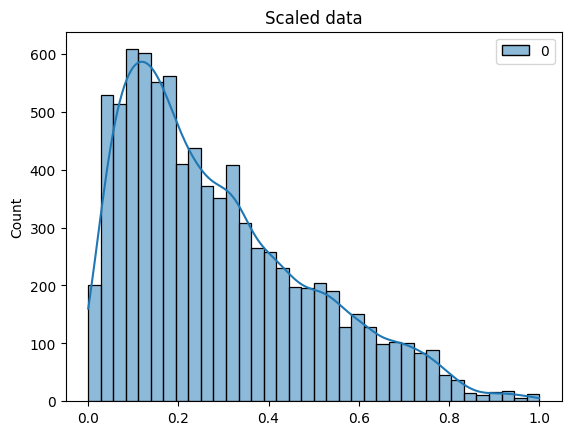

In [238]:
# Scaling
scaled_data = MinMaxScaler().fit_transform(store_data['Item_Visibility'].values.reshape(-1, 1))
print("Scaled Data\n",scaled_data)
print("\nNon Scaled data\n",store_data['Item_Visibility'])

ax = sns.histplot(scaled_data, kde=True)
ax.set_title("Scaled data")
plt.show()

Normalized Data 
 [[-1.13160854]
 [-1.06147526]
 [-1.11613639]
 ...
 [-0.71616004]
 [ 1.67234966]
 [-0.50577617]]

Non Normalized data
 0       0.016047
1       0.019278
2       0.016760
3       0.012741
4       0.012741
          ...   
8518    0.056783
8519    0.046982
8520    0.035186
8521    0.145221
8522    0.044878
Name: Item_Visibility, Length: 8436, dtype: float64


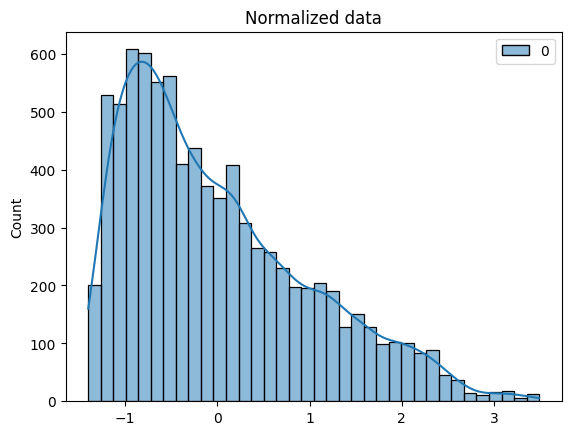

In [239]:
# normalizing data

normalized_data = StandardScaler().fit_transform(store_data['Item_Visibility'].values.reshape(-1, 1))
print("Normalized Data \n",normalized_data)
print("\nNon Normalized data\n",store_data['Item_Visibility'])

ax = sns.histplot(normalized_data, kde=True)
ax.set_title("Normalized data")
plt.show()

# Univariate Analysis

<Axes: xlabel='Item_Outlet_Sales', ylabel='Density'>

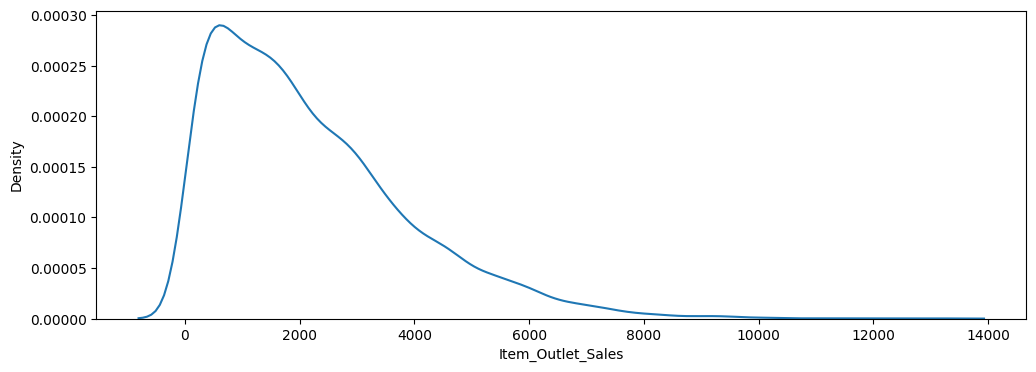

In [240]:
# Scatter plot
plt.figure(figsize=(12,4))

sns.kdeplot(store_data.Item_Outlet_Sales)


(array([3.197e+03, 2.444e+03, 1.527e+03, 7.290e+02, 3.590e+02, 1.240e+02,
        3.600e+01, 1.600e+01, 2.000e+00, 2.000e+00]),
 array([   33.29   ,  1338.65748,  2644.02496,  3949.39244,  5254.75992,
         6560.1274 ,  7865.49488,  9170.86236, 10476.22984, 11781.59732,
        13086.9648 ]),
 <BarContainer object of 10 artists>)

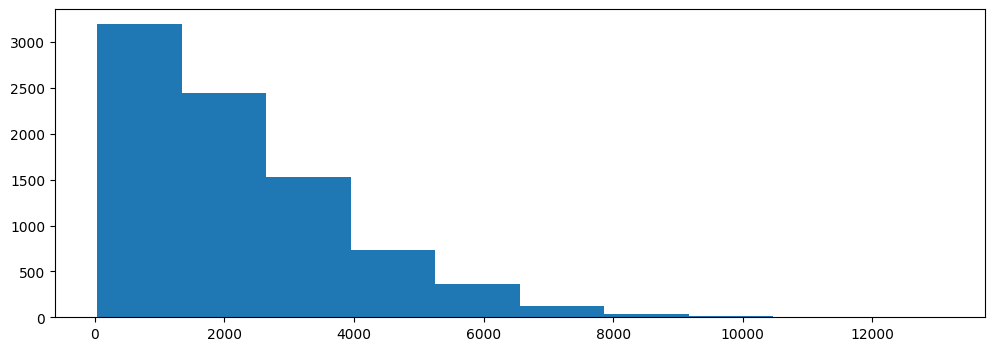

In [241]:
#Histograms
plt.figure(figsize=(12,4))

plt.hist(store_data.Item_Outlet_Sales)


Ofcourse more expensive items are less common



# Bivariate Analysis

<Figure size 1200x600 with 0 Axes>

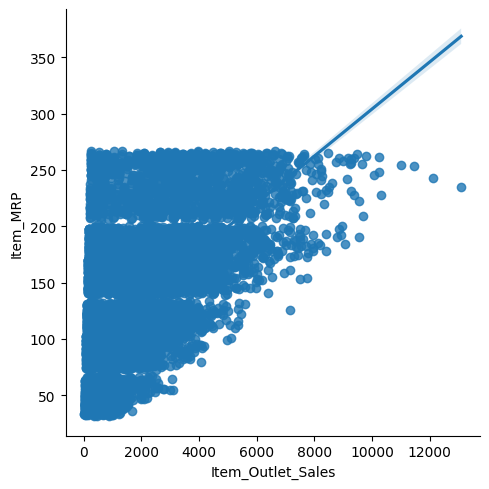

In [242]:
# Scatter plot with regression line
plt.figure(figsize=(12,6))
sns.lmplot(data = store_data, y ='Item_MRP' , x = 'Item_Outlet_Sales')

**There is a positive correlation between sales and the item MRP as the slope of the regression line is a positive slope**

<Axes: xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

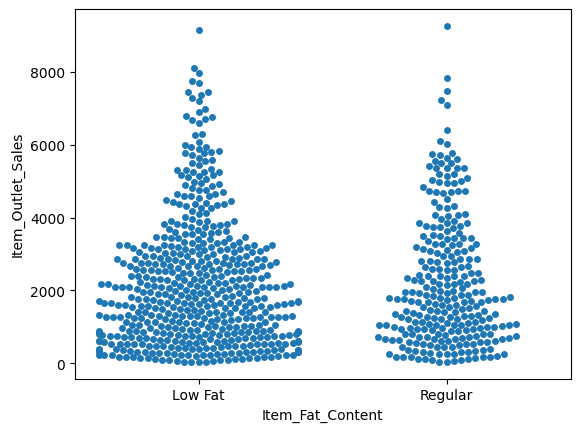

In [243]:
# Swarm plot
sns.swarmplot(x=store_data['Item_Fat_Content'],y=store_data.loc[0:800,'Item_Outlet_Sales'])
# Thre is no relation between fat content and sales as we can see from the next plot i limited the data to the first 800 points as google collabs couldn't handle all the points

# Encoding Categorical Variables

## Label Encoding

In [244]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [245]:
# Get list of categorical variables
cat_col = store_data.select_dtypes(include = ['object'])
cat_col

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,High,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,Small,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


In [246]:
# We will apply Ordinal encoding to columns having more than 10 unique values
# We will apply OH encoding to columns having less than 10 unique values
col_ordi = [col for col in cat_col.columns if (cat_col[col]).nunique() > 10 and (cat_col[col]).nunique() < 10]
col_OH = [col for col in cat_col.columns if (cat_col[col]).nunique() < 10 ]

In [247]:
#Ordinal encoding
prices = store_data.Item_Outlet_Sales
store_data = store_data.drop("Item_Outlet_Sales",axis=1)
store_data_train , store_data_valid, prices_train, prices_valid = train_test_split(store_data, prices, train_size = 0.8, test_size = 0.2 ,random_state = 0)

good_label_cols = [col for col in cat_col if set(store_data_valid[col]).issubset(set(store_data_train[col]))]
bad_label_cols = list(set(cat_col)-set(good_label_cols)) #badcols should be dropped to make valid ordinal encodin

store_data_train = store_data_train.drop(bad_label_cols, axis=1)
store_data_valid = store_data_valid.drop(bad_label_cols, axis=1)

ordinal_encoder = OrdinalEncoder()
# I Will fit on the entire data set and than transform on the validation as there is a column that has a very high number of unique values
store_data_train[good_label_cols] = ordinal_encoder.fit_transform(store_data_train[good_label_cols])

store_data_valid[good_label_cols] = ordinal_encoder.transform(store_data_valid[good_label_cols])
print("MAE score from Ordinal encoding:")
print(score_dataset(store_data_train, store_data_valid,prices_train,prices_valid))

MAE score from Ordinal encoding:
767.0127190177725


## One Hot Encoding


In [248]:
#OH Encoding
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(store_data_train[col_OH]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(store_data_valid[col_OH]))

#Reassign removed indexes
OH_cols_train.index =  store_data_train.index
OH_cols_valid.index = store_data_valid.index

#Drop the columns that were OH encoded
num_X_train = store_data_train.drop(col_OH, axis=1)
num_X_valid = store_data_valid.drop(col_OH, axis=1)

#Mash the two lists together
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_train

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,0,1,2,3,4,5,6,7,8,9,10,11
5505,16.700,0.022190,4.0,113.1886,2.0,2007,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1820,8.390,0.024343,5.0,113.6176,2.0,2007,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6273,19.500,0.014355,9.0,55.4614,2.0,2007,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6552,7.550,0.031007,6.0,123.4072,7.0,2002,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8207,16.250,0.049075,6.0,154.2682,7.0,2002,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420,20.850,0.037480,5.0,192.7478,7.0,2002,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7974,13.150,0.043764,13.0,183.0950,8.0,1997,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4910,5.695,0.109784,5.0,256.0646,0.0,1998,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3299,5.695,0.067688,1.0,258.8988,6.0,2004,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [249]:
OH_X_valid

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,0,1,2,3,4,5,6,7,8,9,10,11
4688,16.100,0.064577,10.0,230.5352,4.0,1985,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4300,7.145,0.017887,5.0,160.6578,2.0,2007,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
50,7.390,0.067780,8.0,143.8812,8.0,1997,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4383,8.355,0.074806,4.0,112.9176,5.0,1985,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5163,5.365,0.064607,3.0,87.4198,5.0,1985,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6726,9.300,0.014041,13.0,199.1084,9.0,1999,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1178,6.365,0.007348,5.0,62.8536,8.0,1997,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6750,15.000,0.026818,0.0,219.7456,1.0,1987,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7917,12.500,0.109901,6.0,83.0592,1.0,1987,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [250]:
#Encoding test data
cat_col = test_data.select_dtypes(include = ['object'])

# We will apply Ordinal encoding to columns having more than 10 unique values
# We will apply OH encoding to columns having less than 10 unique values
col_ordi = [col for col in cat_col.columns if (cat_col[col]).nunique() > 10 and (cat_col[col]).nunique() < 10]
col_OH = [col for col in cat_col.columns if (cat_col[col]).nunique() < 10 ]

#Ordinal encoding

# store_data_train , store_data_valid, prices_train, prices_valid = train_test_split(store_data, prices, train_size = 0.8, test_size = 0.2 ,random_state = 0)

ordinal_encoder = OrdinalEncoder()
# I Will fit on the entire data set and than transform on the validation as there is a column that has a very high number of unique values

test_data[col_ordi] = ordinal_encoder.fit_transform(test_data[col_ordi])

#OH Encoding
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(store_data_train[col_OH]))

#Reassign removed indexes
OH_cols_test.index =  store_data_train.index

#Drop the columns that were OH encoded
num_X_train = store_data_train.drop(col_OH, axis=1)

#Mash the two lists together
OH_cols_test = pd.concat([num_X_train, OH_cols_test], axis=1)

OH_cols_test.columns = OH_cols_test.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [251]:
OH_cols_test

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,0,1,2,3,4,5,6,7,8,9,10,11
5505,16.700,0.022190,4.0,113.1886,2.0,2007,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1820,8.390,0.024343,5.0,113.6176,2.0,2007,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6273,19.500,0.014355,9.0,55.4614,2.0,2007,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6552,7.550,0.031007,6.0,123.4072,7.0,2002,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8207,16.250,0.049075,6.0,154.2682,7.0,2002,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420,20.850,0.037480,5.0,192.7478,7.0,2002,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7974,13.150,0.043764,13.0,183.0950,8.0,1997,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4910,5.695,0.109784,5.0,256.0646,0.0,1998,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3299,5.695,0.067688,1.0,258.8988,6.0,2004,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Modeling

## Linear Regression

In [252]:
# Initializing the linear regression model
model_LinearRegression = LinearRegression()

# Fitting the model on the training data
model_LinearRegression.fit(OH_X_train, prices_train)

# Predicting the target variable for the test data
y_pred = model_LinearRegression.predict(OH_X_valid)

# Evaluating the model using mean squared error
mse = mean_squared_error(prices_valid, y_pred)
print("Mean Squared Error:", mse)
print("MAE score from Linear Regression:", mean_absolute_error(prices_valid, y_pred))

Mean Squared Error: 1194188.3071896385
MAE score from Linear Regression: 822.1334524318718


## Regularized linear regression

In [253]:
# Preprocessing the data using standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(OH_X_train)
X_test_scaled = scaler.transform(OH_X_valid)

# Ridge Regression
ridge = Ridge(alpha=0.5)  # Alpha is the regularization strength
ridge.fit(X_train_scaled, prices_train)
y_pred_ridge = ridge.predict(X_test_scaled)
mse_ridge = mean_squared_error(prices_valid, y_pred_ridge)
print("Ridge Regression Mean Squared Error:", mse_ridge)
print("MAE score from Regularized Linear Regression[Ridge]:", mean_absolute_error(prices_valid, y_pred))


Ridge Regression Mean Squared Error: 1194174.9003740032
MAE score from Regularized Linear Regression[Ridge]: 822.1334524318718


## RandomForest

In [254]:
# Defining the model
model_RF = RandomForestRegressor(random_state = 1)

# Fitting the model
model_RF.fit(OH_X_train,prices_train)
y_pred = model_RF.predict(OH_X_valid)

print("MAE score from RandomForest:", mean_absolute_error(prices_valid, y_pred))

MAE score from RandomForest: 768.6041585118484


## XGBoost

In [255]:
#Defining the model
model_XG = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state = 0)
model_XG.fit(OH_X_train, prices_train,
             early_stopping_rounds=15,
             eval_set=[(OH_X_valid, prices_valid)],
             verbose=False)
y_pred = model_XG.predict(OH_X_valid)
print("MAE score from XG boost:", mean_absolute_error(prices_valid, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE score from XG boost: 732.9936511624594


In [260]:
# I will use the best model to work on our Test.csv file to get the most accurate results
y_pred = model_XG.predict(OH_cols_test)
y_pred
OH_cols_test['Item_Outlet_Sales'] = y_pred

In [261]:
OH_cols_test.to_csv('submission.csv', index=False)

# Summary
- I began by loading all the packages and the data, and checking the data
- I cleaned the null values in the data by using bfill, and cleaned the data in the Item_Type.
- I removed the outliers in the Item_Visibility column.
- I scaled and normalized the data.
- I used Several plots to illustrate the data to get a better understanding about the data.
- I used several encoding techniques like Label Encoding (ordinal encoding) and One Hot Encoding.
- I used different Machine learning models to predict the data so we can predict the data in the Test.csv
- The models used were:[Linear Regression, Regularized Linear Regression, RandomForest,XGBoost]
